[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain)

# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph
%pip install --quiet -U langchain_google_genai langchain_core langchain_community tavily-python

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to choose from! Let's work with OpenAI. 

Let's check that your `OPENAI_API_KEY` is set and, if not, you will be asked to enter it.

In [3]:
import os
import dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
# Set up OpenAI (GitHub) credentials
if not os.getenv("GITHUB_TOKEN"):
    raise ValueError("GITHUB_TOKEN is not set")

os.environ["OPENAI_API_KEY"] = os.getenv("GITHUB_TOKEN")
os.environ["OPENAI_BASE_URL"] = "https://models.inference.ai.azure.com/"

In [5]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# Set Google API Key
_set_env("GOOGLE_API_KEY")




We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage

# Initialize the Gemini model
model = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash-latest",  # Specify the Gemini model variant
    temperature=0.6  # Set temperature to control randomness
)


In [7]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
llm1 = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")
result1 = llm1.invoke(messages)
type(result1)

langchain_core.messages.ai.AIMessage

In [8]:
result1

AIMessage(content="That's a great question!  Orcas, also known as killer whales, are truly fascinating creatures.  \n\nTo help me recommend the best place for you, could you tell me a little more about what you're looking for? For example:\n\n* **What time of year are you planning to travel?**  Orca sightings vary seasonally depending on their migration patterns.\n* **Do you prefer a land-based or water-based experience?**  You can see orcas from whale watching tours, kayaking trips, or even from the shore.\n* **What kind of experience are you hoping for?** Do you want to see orcas in a wild, natural setting, or are you interested in a more interactive experience?\n* **What is your budget?**  Whale watching tours can range in price depending on the location and type of experience.\n\nOnce I have a better understanding of your preferences, I can give you some specific recommendations. \n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': 

In [9]:
result1.response_metadata

{'prompt_feedback': {'block_reason': 0, 'safety_ratings': []},
 'finish_reason': 'STOP',
 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT',
   'probability': 'NEGLIGIBLE',
   'blocked': False},
  {'category': 'HARM_CATEGORY_HATE_SPEECH',
   'probability': 'NEGLIGIBLE',
   'blocked': False},
  {'category': 'HARM_CATEGORY_HARASSMENT',
   'probability': 'NEGLIGIBLE',
   'blocked': False},
  {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT',
   'probability': 'NEGLIGIBLE',
   'blocked': False}]}

In [10]:
# Initialize the OpenAI model
llm2 = ChatOpenAI(model="gpt-4o")

# Invoke the model with the same messages
result2 = llm2.invoke(messages)
result2

AIMessage(content='One of the best places to see orcas in the US is the San Juan Islands in Washington State. Here are a few things to know:\n\n1. **Location**: The San Juan Islands are located in the Pacific Northwest, accessible by ferry from Anacortes, Washington.\n\n2. **Orca Pods**: The area is home to both resident and transient orca pods. The Southern Resident Killer Whales are the most well-known, though their population is considered endangered.\n\n3. **Best Time to Visit**: The prime time for orca sightings is typically from late spring to early fall, with the peak being around June to September.\n\n4. **Tours**: There are numerous whale-watching tours departing from Friday Harbor and other parts of the islands, offering guided experiences to see these magnificent creatures.\n\n5. **Conservation**: It’s essential to choose responsible tour operators who follow guidelines to minimize disturbance to the whales.\n\nLet me know if you need more information!', additional_kwargs={'

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language. 

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user. 

And, it will return an output that adheres to the tool's schema. 

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple. 
 
You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!
 
The `multiply` function is our tool.

In [11]:
from langchain_core.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm2.bind_tools([multiply])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [14]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NG7yFh4ckmeIL1afB335pPEP', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 68, 'total_tokens': 85, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_67802d9a6d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-dc926ee3-3b85-44ac-af4f-7ad29b798c79-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_NG7yFh4ckmeIL1afB335pPEP', 'type': 'tool_call'}], usage_metadata={'input_tokens': 68, 'output_tokens': 17, 'total_tokens': 85})

In [13]:
# Invoke the model
response = llm_with_tools.invoke([HumanMessage(content="What is 2 multiplied by 3?")])

# Access tool calls
tool_call = response.tool_calls[0]
print(tool_call)

{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_NHeP7mR0DTrEURAujFE51LZb', 'type': 'tool_call'}


In [15]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_NG7yFh4ckmeIL1afB335pPEP',
  'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'},
  'type': 'function'}]

In [21]:
result = multiply(tool_call['args']['a'], tool_call['args']['b'])
print(f"Result: {result}")  # Output: 6


AttributeError: 'float' object has no attribute 'parent_run_id'

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [16]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem! 

As we discussed, each node will return a new value for our state key `messages`.

But, this new value will [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.
 
As our graph runs, we want to **append** messages to to our `messages` state key.
 
We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.
 
But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We annotate simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [17]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)! 

`MessagesState` is defined: 

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects 
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [18]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [19]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='105754ed-cc8d-4894-bbda-4d8a79906846'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='3036a9b5-9891-47fc-b9ba-6ba556aeb3fa'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='fe964fd6-101c-4186-9d31-81a57af00f18')]

## Our graph

Now, lets use `MessagesState` with a graph.

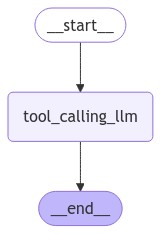

In [20]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [21]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi there! How can I assist you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [22]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_0qXjsJvjdhpEK5y7N7bdhmoJ)
 Call ID: call_0qXjsJvjdhpEK5y7N7bdhmoJ
  Args:
    a: 2
    b: 3
